In [1]:
from pyquil.quil import Program, MEASURE
from pyquil.api import SyncConnection, JobConnection
from pyquil.job_results import wait_for_job
from pyquil.gates import CZ, H, I, X
import numpy as np

In [2]:
# TODO delete me before committing
cxn = SyncConnection(endpoint="http://localhost:5000")

In [3]:
def append_damping_to_gate(gate, damp_prob=.1):
    """
    Generate the Kraus operators corresponding to a given unitary 
    single qubit gate followed by an amplitude damping noise channel.
    
    :params np.ndarray|list gate: The 2x2 unitary gate matrix.
    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    damping_op = np.sqrt(damp_prob) * np.array([[0, 1],
                                                [0, 0]])
    
    residual_kraus = np.sqrt(np.eye(2) - damping_op.T.conjugate().dot(damping_op))
    return [residual_kraus.dot(gate), damping_op.dot(gate)]

In [4]:
%%time
cxn = SyncConnection(endpoint="http://localhost:5000")
# cxn = JobConnection(endpoint="http://localhost:5000")

damping_per_I = 0.02
trials = 100

results = []
outcomes = []
lengths = np.arange(0, 101, 5, dtype=int)
for num_I in lengths:
    print("Simulating for num_I={}".format(num_I))
    
    p = Program(X(0))
    # want increasing number of I-gates
    p.inst([I(0) for _ in range(num_I)])
    p.inst(MEASURE(0, [0]))
    
    # overload identity I on qc 0
    p.define_noisy_gate("I", [0], append_damping_to_gate(np.eye(2), damping_per_I))
    cxn.random_seed = int(num_I)
    res = cxn.run(p, [0], trials=trials)
    results.append([np.mean(res), np.std(res) / np.sqrt(trials)])
    
results = np.array(results)

Simulating for num_I=0
Simulating for num_I=5
Simulating for num_I=10
Simulating for num_I=15
Simulating for num_I=20
Simulating for num_I=25
Simulating for num_I=30
Simulating for num_I=35
Simulating for num_I=40
Simulating for num_I=45
Simulating for num_I=50
Simulating for num_I=55
Simulating for num_I=60
Simulating for num_I=65
Simulating for num_I=70
Simulating for num_I=75
Simulating for num_I=80
Simulating for num_I=85
Simulating for num_I=90
Simulating for num_I=95
Simulating for num_I=100
CPU times: user 82.6 ms, sys: 13.4 ms, total: 96.1 ms
Wall time: 22.1 s


In [5]:
survival_probs = (1-damping_per_I)**lengths

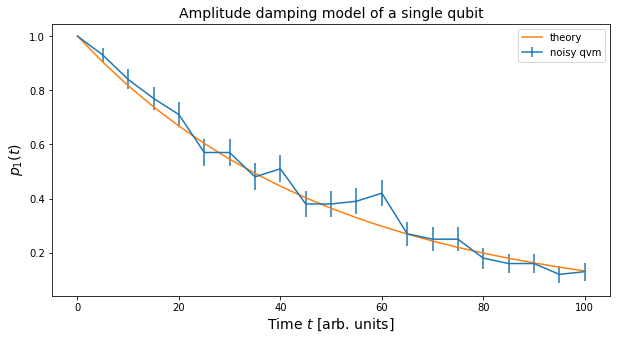

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.errorbar(lengths, results[:,0], yerr=results[:,1], label="noisy qvm")
plt.plot(lengths, survival_probs, label="theory")
plt.title("Amplitude damping model of a single qubit", size=14)
plt.xlabel(r"Time $t$ [arb. units]", size=14)
plt.ylabel(r"$p_1(t)$", size=14)
plt.legend(loc="best")